In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
# preparing data
DATA_PATH = pathlib.Path("../data/Sample-DS.csv")

df = pd.read_csv(DATA_PATH)

df["DateTime"] = pd.to_datetime(
    df.Date.astype(str) + " " + df.Hour.astype(str) + ":00:00"
)
df.set_index("DateTime", inplace=True)
df["Weekday"].replace(dict(zip(df["Weekday"].unique(), range(1, 8))), inplace=True)
df.rename(columns={"HOEP": "Price"}, inplace=True)
df.sort_index(inplace=True)
df.drop(["Hour", "Weekday", "Pressure_Station", "Date"], axis=1, inplace=True)

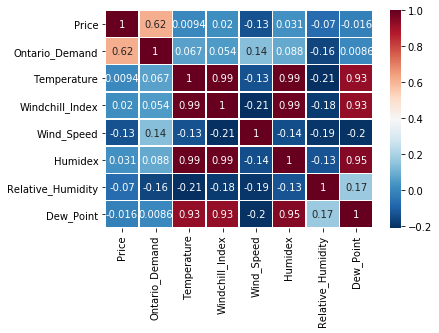

In [6]:
# Checking Correlataion
pearsoncorr = df.corr(method="pearson")

sns.heatmap(
    pearsoncorr,
    xticklabels=pearsoncorr.columns,
    yticklabels=pearsoncorr.columns,
    cmap="RdBu_r",
    annot=True,
    linewidth=0.5,
)

plt.show()

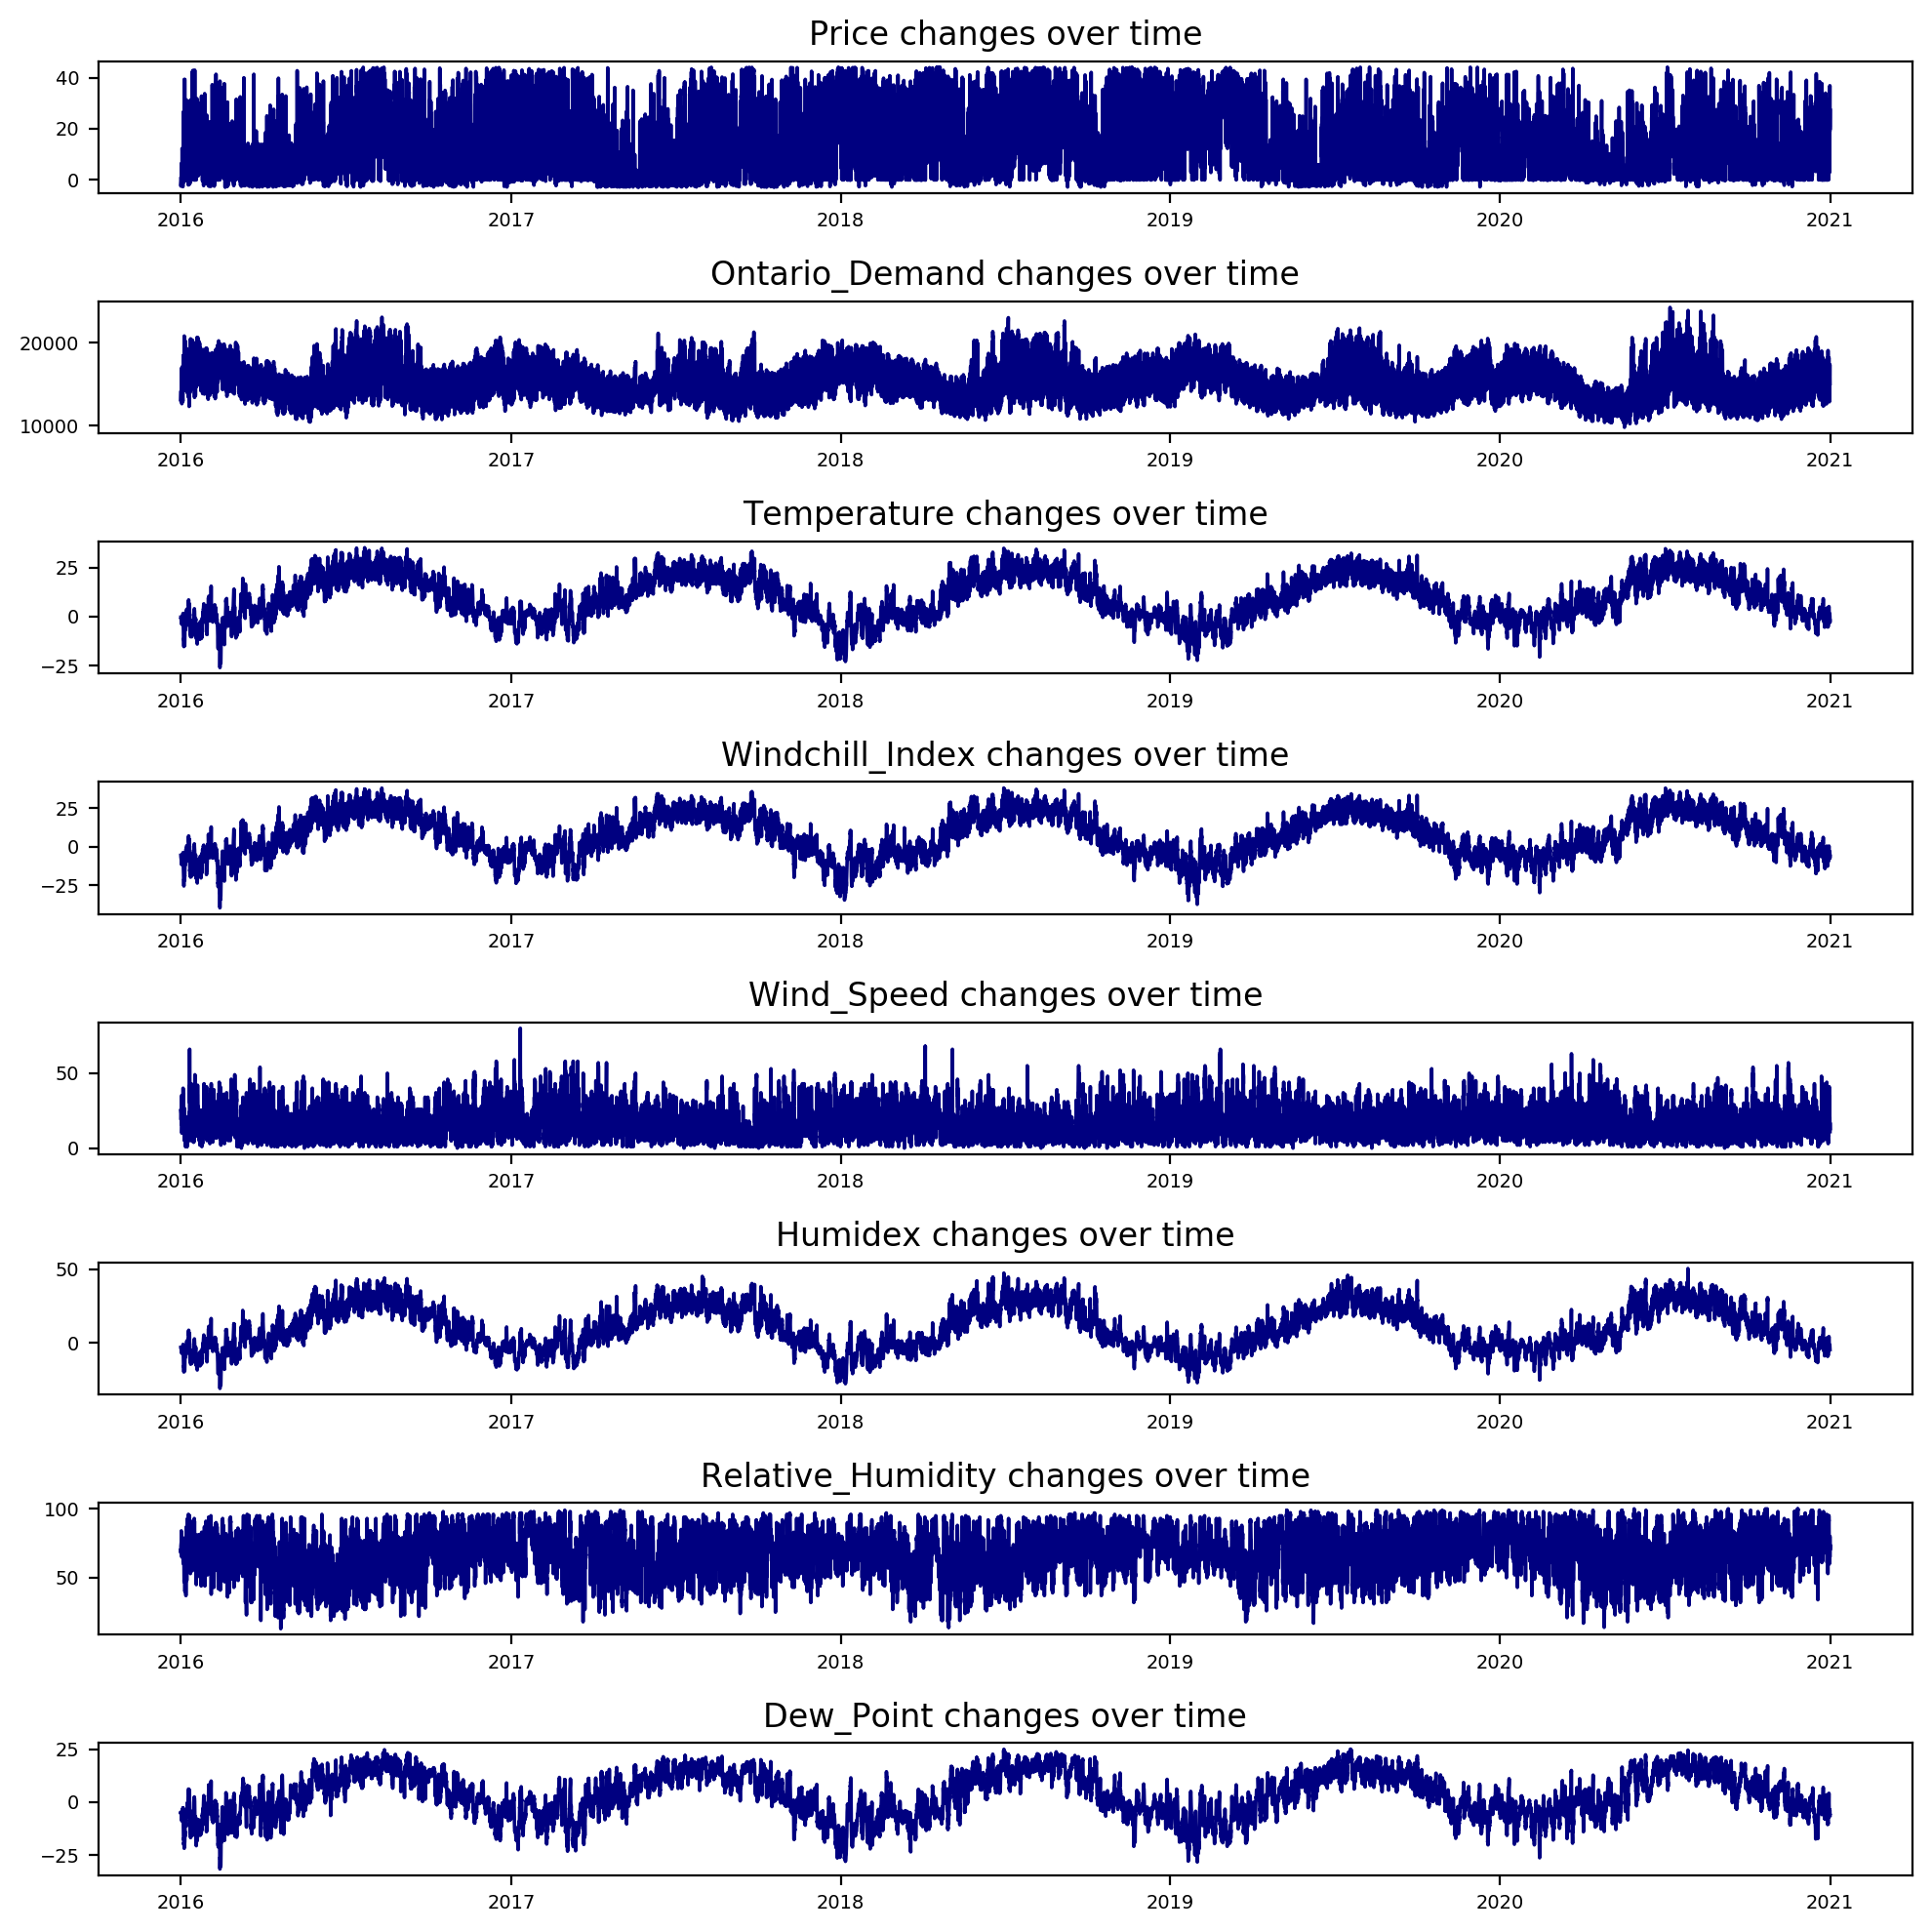

In [7]:
# Plot time series
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, dpi=200, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color="navy", linewidth=1.3)
    # Decorations
    ax.set_title(f"{df.columns[i]} changes over time")
    ax.tick_params(labelsize=7)

plt.tight_layout()

In [8]:
# SPLIT TRAIN TEST
nobs = int(len(df) * 0.2)

train_data, test_data = df[:-nobs], df[-nobs:]

# Check size
print(f"train data size: {train_data.shape}\ntest data size: {test_data.shape}")

train data size: (31527, 8)
test data size: (7881, 8)


In [9]:
def adfuller_test(series, signif=0.05, name="", verbose=False):
    """Perform ADFuller test for stationarity of given series and give report.

    Args:
        series (pandas.series): Series to test for stationarity.
        signif (float, optional): significance level for critical values. Defaults to 0.05.
        name (str, optional): string to identify data set in report. Defaults to "".
        verbose (bool, optional): print additional information. Defaults to False.
    Returns:
        str: report of ADFuller test.
    """

    result = adfuller(series, autolag="AIC")
    output = {
        "test_statistic": round(result[0], 4),
        "pvalue": round(result[1], 4),
        "n_lags": round(result[2], 4),
        "n_obs": result[3],
    }
    p_value = output["pvalue"]

    # print ADF report
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", "-" * 47)
    print(" Null Hypothesis: Data has unit root. Non-Stationary.")
    print(f" Significance Level    = {signif}")
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key, val in result[4].items():
        print(f" Critical value {key} = {round(val, 3)}")

    # check for stationary
    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(" => Series is Non-Stationary.")


In [10]:
# ADF Test on each column
for name, column in train_data.iteritems():
    adfuller_test(column, name=column.name)
    print("\n")


    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.314
 No. Lags Chosen       = 46
 Critical value 1% = -3.431
 Critical value 5% = -2.862
 Critical value 10% = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Ontario_Demand" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.8584
 No. Lags Chosen       = 48
 Critical value 1% = -3.431
 Critical value 5% = -2.862
 Critical value 10% = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

In [11]:
# 1st difference to remove seasonality
train_diff1 = train_data.diff().dropna()
diff_lag = 1

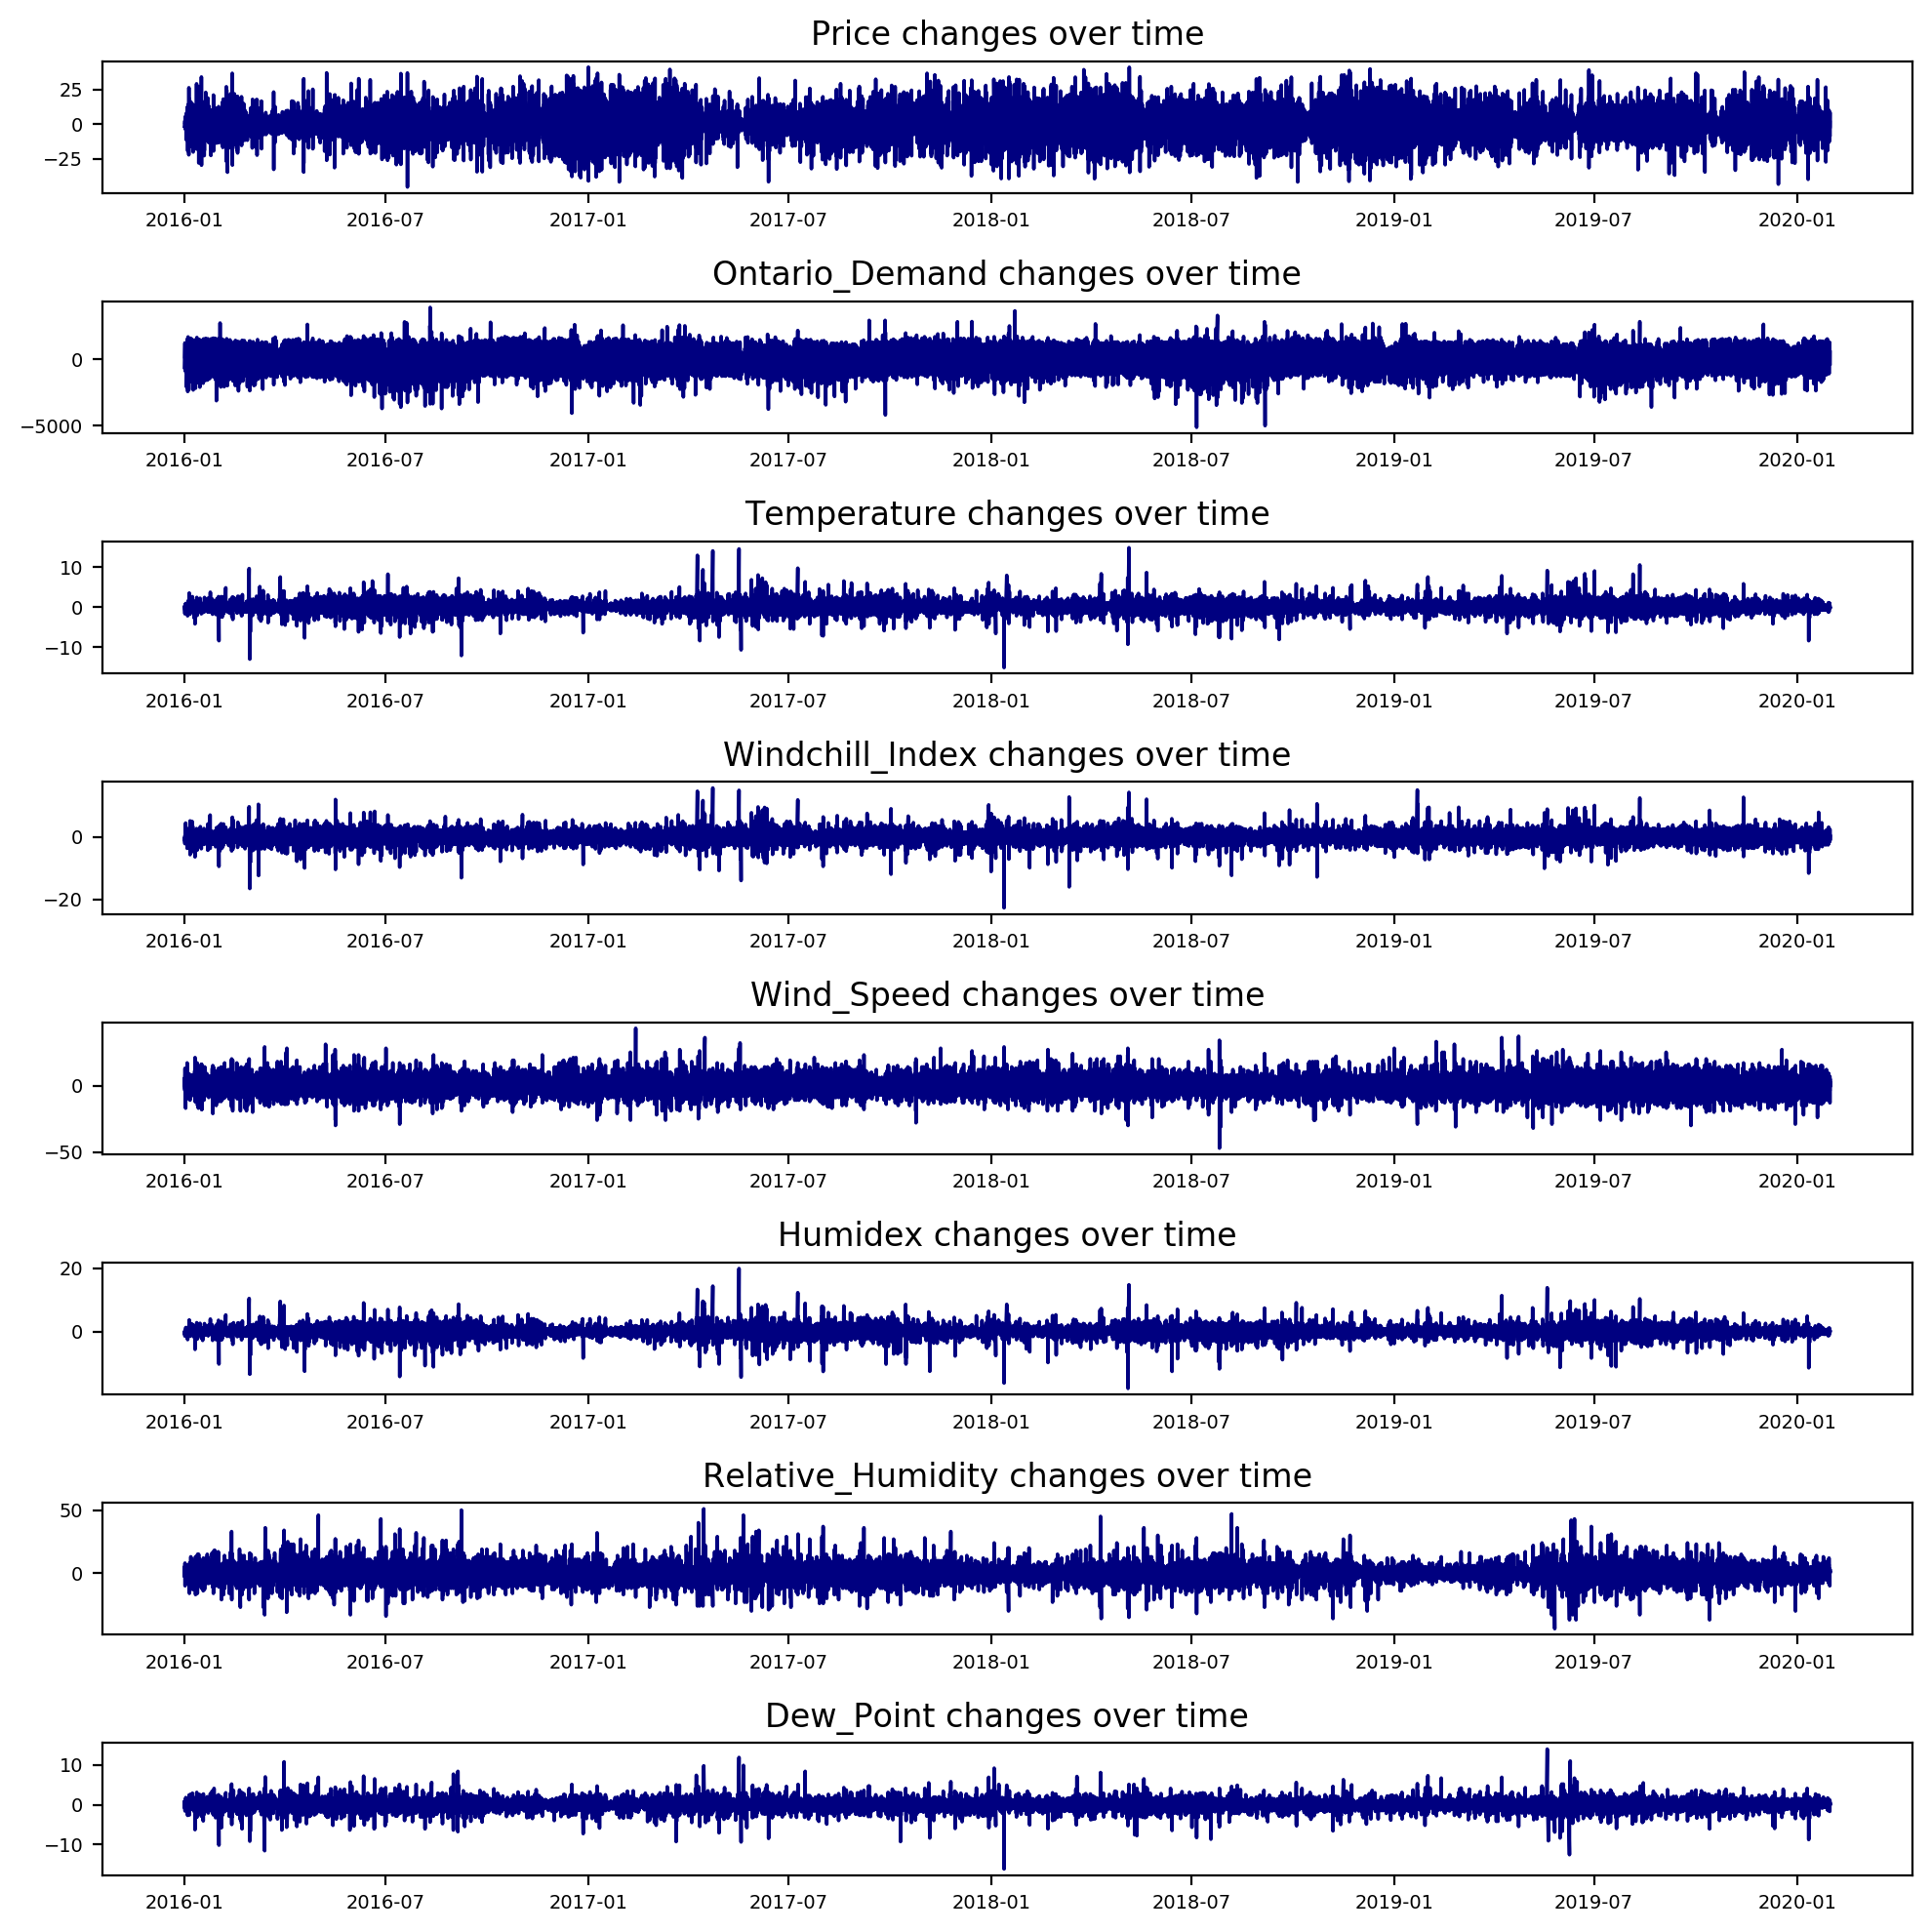

In [12]:
# Plot
fig, axes = plt.subplots(
    nrows=len(train_diff1.columns), ncols=1, dpi=200, figsize=(10, 10)
)
for i, ax in enumerate(axes.flatten()):
    data = train_diff1[train_diff1.columns[i]]
    ax.plot(data, color="navy", linewidth=1.3)

    ax.set_title(f"{train_diff1.columns[i]} changes over time")
    ax.spines["top"]
    ax.tick_params(labelsize=7)

plt.tight_layout()


In [13]:
def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df, -1, 1)
    d = {"0.90": 0, "0.95": 1, "0.99": 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1 - alpha)]]

    # Summary
    print("Name   ::  Test Stat > C(95%)    =>   Signif  \n", "--" * 20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(col, ":: ", round(trace, 2), ">", cvt, " =>  ", trace > cvt)


cointegration_test(train_diff1)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price ::  125243.04 > 143.6691  =>   True
Ontario_Demand ::  97449.91 > 111.7797  =>   True
Temperature ::  75145.79 > 83.9383  =>   True
Windchill_Index ::  54598.05 > 60.0627  =>   True
Wind_Speed ::  35858.31 > 40.1749  =>   True
Humidex ::  23638.36 > 24.2761  =>   True
Relative_Humidity ::  12881.98 > 12.3212  =>   True
Dew_Point ::  4705.43 > 4.1296  =>   True


In [14]:
# fit VAR model on training data 
model = VAR(endog=train_diff1.values)
model_var = model.fit(maxlags=10)
model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Mar, 2022
Time:                     15:30:28
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    18.3899
Nobs:                     31516.0    HQIC:                   18.2730
Log likelihood:          -644186.    FPE:                8.16561e+07
AIC:                      18.2180    Det(Omega_mle):     7.99964e+07
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.001218         0.038046            0.032           0.974
L1.y1         -0.417583         0.006024          -69.324           0.000
L1.y2          0.003102         0.000083           37.348           0.000
L1.y3         -0.

In [15]:
#x = model.select_order(maxlags=10)
#x.summary

In [16]:
out = durbin_watson(model_var.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Price : 2.0
Ontario_Demand : 2.01
Temperature : 2.02
Windchill_Index : 2.01
Wind_Speed : 2.0
Humidex : 2.01
Relative_Humidity : 2.01
Dew_Point : 2.0


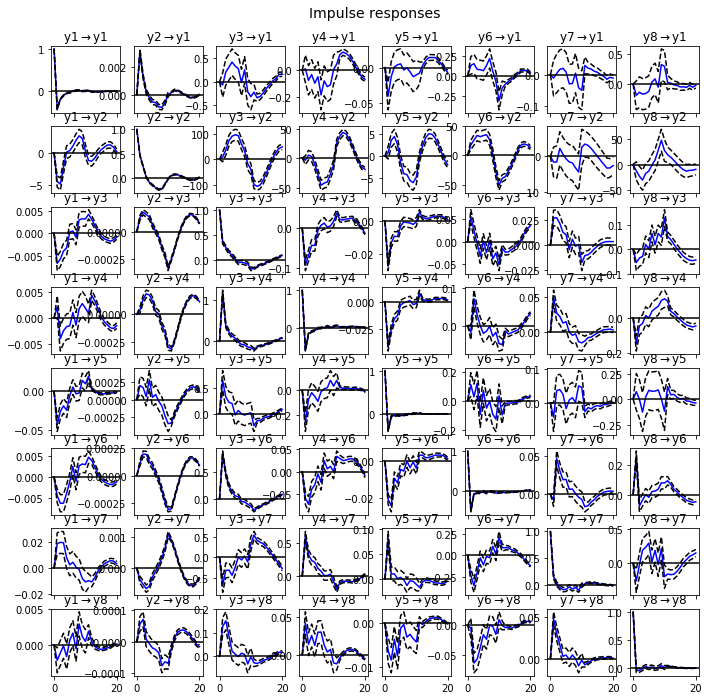

In [17]:
#Implulse Response Analysis
irf = model_var.irf(20)
irf.plot()
plt.show()

In [39]:
# Get the lag order
lag_order = model_var.k_ar
print(f"lag_order : {lag_order}")

# Input data for forecasting
forecast_input = train_diff1.values[-lag_order:]
forecast_input.shape

lag_order : 10


(10, 8)

In [40]:
# Forecast
fc = model_var.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=test_data.index[:], columns=df.columns)

In [41]:
test_inv = df[-nobs - diff_lag :]
var_result_Price = [
    df_forecast["Price"].iloc[i] + test_inv["Price"].iloc[i + 1]
    for i in range(len(df_forecast))
]
var_results = pd.DataFrame(index=test_data.index[:])
var_results["Price_forecast"] = var_result_Price

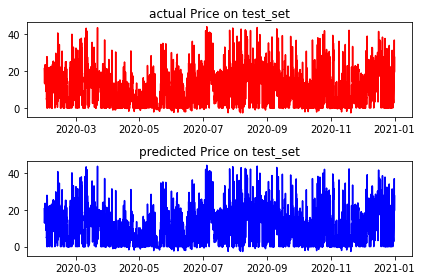

In [42]:
fig, ax = plt.subplots(2)
ax[0].set_title("actual Price on test_set")
ax[0].plot(df["Price"][-nobs:], c="r")

ax[1].set_title("predicted Price on test_set")
ax[1].plot(var_results["Price_forecast"], c="b")
plt.tight_layout()

In [29]:
def forecast_accuracy(actual, forecast):
    """repprt the accuracy of a forecast"""
    rmse = np.mean((forecast - actual) ** 2) ** 0.5
    mse = mean_squared_error(forecast, actual)
    rmse2 = np.sqrt(mse)

    return {"mse": mse, "rmse": rmse}


print("Forecast Accuracy of: confirmed")
accuracy_prod = forecast_accuracy(
    test_data["Price"], var_results["Price_forecast"].values
)
for k, v in accuracy_prod.items():
    print(k, ": ", round(v, 4))

Forecast Accuracy of: confirmed
mse :  0.001
rmse :  0.0309
